<a href="https://colab.research.google.com/github/akshita119/vehicleNumberPlateRecognition/blob/main/numberPlateExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshita119","key":"b83a12403e6e1a0e59856c60d199c23a"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d aslanahmedov/number-plate-detection

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection
License(s): copyright-authors
 96% 397M/413M [00:03<00:00, 137MB/s]
100% 413M/413M [00:03<00:00, 110MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('number-plate-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import shutil
import random

# Create main data directory
os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/data/train", exist_ok=True)
os.makedirs("/content/data/test", exist_ok=True)
os.makedirs("/content/data/val", exist_ok=True)

# Define paths
input_folder = '/content/images'
output_folder = '/content/data'
train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

# Create necessary directories for images and labels
os.makedirs(os.path.join(train_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_folder, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'labels'), exist_ok=True)

# Get list of all .jpeg and .xml files
image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpeg')]
xml_files = [f for f in os.listdir(input_folder) if f.endswith('.xml')]

# Print counts for debugging
print(f"Number of .jpeg files: {len(image_files)}")
print(f"Number of .xml files: {len(xml_files)}")


# Shuffle the files for randomness
random.shuffle(image_files)

# Calculate split indices
total_images = len(image_files)
train_end = int(0.8 * total_images)
val_end = int(0.95 * total_images)

# Split the files
train_images = image_files[:train_end]
val_images = image_files[train_end:val_end]
test_images = image_files[val_end:]

# Function to copy files with error handling
def copy_files(file_list, source_folder, dest_folder):
    for file in file_list:
        try:
            # Copy image
            shutil.copy(os.path.join(source_folder, file), os.path.join(dest_folder, 'images', file))

            # Copy corresponding XML file
            xml_file = file.replace('.jpeg', '.xml')  # Replace .jpeg with .xml
            shutil.copy(os.path.join(source_folder, xml_file), os.path.join(dest_folder, 'labels', xml_file))

        except FileNotFoundError:
            print(f"File not found: {file} or its corresponding XML file.")
        except Exception as e:
            print(f"Error copying {file} or its corresponding XML file: {e}")

# Move images and XML files to their respective folders
copy_files(train_images, input_folder, train_folder)
copy_files(val_images, input_folder, val_folder)
copy_files(test_images, input_folder, test_folder)

print("Images and XML files have been successfully split into train, validation, and test sets.")


Number of .jpeg files: 228
Number of .xml files: 225
File not found: N180.jpeg or its corresponding XML file.
File not found: N182.jpeg or its corresponding XML file.
File not found: N249.jpeg or its corresponding XML file.
Images and XML files have been successfully split into train, validation, and test sets.


In [6]:
import os
import xml.etree.ElementTree as ET

# Define the paths for the labels
train_labels_path = '/content/data/train/labels'
val_labels_path = '/content/data/val/labels'
test_labels_path = '/content/data/test/labels'

# Define a function to convert XML to YOLO format
def convert_voc_to_yolo(xml_file, image_width, image_height):
    yolo_annotations = []

    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for obj in root.findall('object'):
        # Get bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        # Append YOLO formatted string to the list
        yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")

    return yolo_annotations

# Function to process each folder
def process_folder(folder_path):
    for xml_file in os.listdir(folder_path):
        if xml_file.endswith('.xml'):
            # Construct full path
            xml_path = os.path.join(folder_path, xml_file)

            # Get the image name (without extension)
            image_name = os.path.splitext(xml_file)[0] + '.jpeg'  # Assuming images are in .jpeg format

            # Get image size from XML
            tree = ET.parse(xml_path)
            root = tree.getroot()
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            # Convert to YOLO format
            yolo_annotations = convert_voc_to_yolo(xml_path, width, height)

            # Write to the corresponding .txt file
            yolo_file_path = os.path.join(folder_path, image_name.replace('.jpeg', '.txt'))
            with open(yolo_file_path, 'w') as yolo_file:
                for annotation in yolo_annotations:
                    yolo_file.write(annotation + '\n')

# Process each label folder
process_folder(train_labels_path)
process_folder(val_labels_path)
process_folder(test_labels_path)

print("Conversion from Pascal VOC to YOLO format is complete.")


Conversion from Pascal VOC to YOLO format is complete.


In [7]:
import os

label_directories = [
    '/content/data/train/labels',
    '/content/data/val/labels',
    '/content/data/test/labels'
]

def remove_xml_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.xml'):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)

# Remove .xml files from each label dir
for label_dir in label_directories:
    remove_xml_files(label_dir)

print("All .xml files have been removed from the specified label directories.")


All .xml files have been removed from the specified label directories.


In [8]:
import shutil
shutil.rmtree("/content/images")



In [9]:
import shutil

source_path = '/content/data.yaml'
destination_path = '/content/data/data.yaml'

shutil.move(source_path, destination_path)

print("File moved successfully.")


File moved successfully.


In [10]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 24.5 MB/s eta 0:00:00


In [11]:
!pip install torch torchvision


In [12]:
! git clone https://github.com/ultralytics/ultralytics.git


Cloning into 'ultralytics'...
remote: Enumerating objects: 45218, done.
remote: Counting objects: 100% (1553/1553), done.
remote: Compressing objects: 100% (858/858), done.
remote: Total 45218 (delta 1106), reused 1044 (delta 691), pack-reused 43665 (from 1)
Receiving objects: 100% (45218/45218), 38.06 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (33565/33565), done.


In [13]:


%cd /content




/content


In [14]:
!nvidia-smi


Thu Oct 31 08:04:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


Ultralytics 8.3.25 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/data/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/train/labels... 180 images, 2 backgrounds, 0 corrupt: 100%|██████████| 182/182 [00:00<00:00, 1753.13it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/val/labels... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 1835.23it/s]

val: New cache created: /content/data/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.46G      1.444      3.805      1.358         13        640: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         34         34    0.00324      0.971      0.755      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.36G      1.212      2.343      1.103         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         34         34          1      0.736      0.902      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.36G      1.224      1.911      1.117         15        640: 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         34         34          1      0.571      0.845      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.37G      1.272      1.833       1.13         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

                   all         34         34          1      0.389      0.658      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.37G      1.258      1.703       1.13         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

                   all         34         34      0.688      0.206      0.343      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.36G      1.344      1.702      1.147         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         34         34      0.873      0.405      0.803      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.36G      1.298      1.633      1.185         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         34         34      0.807      0.676      0.797      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.36G      1.332      1.673      1.184         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

                   all         34         34      0.754      0.618      0.645      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.36G      1.274      1.503      1.189         17        640: 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         34         34      0.704      0.794      0.816      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.35G      1.197      1.473      1.137         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         34         34      0.766       0.29      0.316      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.35G      1.221      1.349       1.12         11        640: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         34         34      0.789      0.471       0.56      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.35G       1.22      1.313      1.088         15        640: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         34         34      0.423      0.324      0.262      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.35G       1.19      1.279        1.1         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         34         34       0.99      0.912      0.986      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.35G      1.213      1.216       1.12         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         34         34      0.978      0.912       0.98      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.36G      1.212        1.2       1.12         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         34         34      0.835      0.941       0.93      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.35G      1.236      1.203      1.157          8        640: 100%|██████████| 12/12 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         34         34      0.969      0.929      0.967      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.36G      1.236       1.17      1.116         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         34         34      0.979      0.912      0.975      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.36G      1.129      1.042      1.082         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         34         34      0.941      0.934      0.977      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.35G      1.131      1.054      1.097         10        640: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         34         34      0.915          1       0.98      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.36G      1.095      1.038      1.071         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         34         34      0.943          1      0.969      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G      1.153     0.9765      1.082         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         34         34      0.941       0.94      0.948      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.36G      1.107     0.9362      1.072         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         34         34      0.908      0.971      0.977      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.36G      1.112     0.9435      1.065         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         34         34      0.943      0.965      0.972      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.35G      1.059     0.9187      1.071          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         34         34      0.921      0.882      0.959      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.35G      1.054     0.8579      1.067         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         34         34      0.907      0.971      0.969      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.35G       1.13      0.898      1.095          9        640: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         34         34      0.969      0.928       0.98      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.35G      1.144     0.8599      1.098          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34         34      0.992      0.941      0.974      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.36G       1.07     0.8373      1.064         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         34         34          1      0.954      0.986      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.36G       1.04     0.8099      1.004         15        640: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         34         34      0.853      0.941      0.922      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.35G      1.103     0.8157      1.042         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         34         34      0.915      0.971      0.978      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.35G       1.07     0.8082      1.049         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         34         34          1      0.966      0.992      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.35G      1.008     0.7494      1.027         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         34         34      0.961      0.941      0.989      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.35G      1.091     0.8089      1.073         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         34         34          1      0.967      0.993      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.35G      1.038      0.769      1.056         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         34         34          1      0.964      0.993      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.35G     0.9996     0.7381      1.032         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         34         34      0.913          1      0.983      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.35G       1.05      0.746      1.021         12        640: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         34         34      0.892          1      0.977      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.35G     0.9843     0.7293      1.007         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         34         34       0.97      0.963      0.984      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.35G      0.972     0.7258      1.017         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         34         34      0.996      0.971      0.985      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.35G     0.9467      0.712      0.989          9        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         34         34      0.995      0.971      0.994      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.36G      1.014     0.7093      1.029         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         34         34          1      0.967      0.982      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.35G     0.9848     0.7151      1.002         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         34         34      0.993      0.971      0.993      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.35G     0.9779     0.6959       1.02          9        640: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         34         34          1      0.969      0.988      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.35G      1.008     0.7088      1.028         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         34         34      0.954      0.941      0.974       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.35G     0.9316     0.6605      1.013          7        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         34         34      0.968      0.971      0.991      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.35G     0.9624     0.6492      0.997         12        640: 100%|██████████| 12/12 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         34         34          1      0.958      0.991       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.36G     0.9396     0.6297     0.9878         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         34         34          1      0.965      0.992      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.35G     0.9661     0.6719      1.017          5        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         34         34      0.963      0.971       0.99      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.35G     0.9084     0.6293      0.983         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         34         34      0.967      0.971      0.993      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.35G     0.9259     0.6043      0.994          8        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         34         34      0.994      0.971      0.994      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.36G     0.9366      0.633     0.9893          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         34         34      0.992          1      0.995      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.35G      0.901     0.6189      1.007         10        640: 100%|██████████| 12/12 [00:02<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         34         34      0.971      0.994      0.994      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G     0.8897     0.6242     0.9871         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         34         34      0.994          1      0.995      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.36G     0.9026     0.6188      1.002         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         34         34      0.969          1      0.994       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.35G     0.8947     0.6163     0.9739         17        640: 100%|██████████| 12/12 [00:02<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         34         34      0.968          1      0.994      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.36G     0.8634     0.5866     0.9767         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


                   all         34         34          1          1      0.995      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.36G     0.8898     0.6259     0.9904         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

                   all         34         34      0.971      0.999      0.992      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.35G     0.8192     0.5774     0.9578         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         34         34      0.871      0.994      0.982      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.36G      0.879     0.6062     0.9689         12        640: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

                   all         34         34      0.905      0.971      0.969      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.35G     0.8192     0.5705     0.9495          9        640: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         34         34          1      0.995      0.995      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.35G     0.8901     0.6007     0.9903         14        640: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         34         34      0.994          1      0.995       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.36G     0.8681     0.5837     0.9719         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         34         34      0.967          1      0.994       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G     0.8734     0.5901     0.9873         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         34         34      0.995      0.971      0.994      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.35G      0.841     0.5973     0.9814         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         34         34      0.979          1      0.995      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.36G     0.8577     0.5597     0.9765         14        640: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         34         34      0.968          1      0.994      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.35G     0.8816     0.5834     0.9747         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         34         34      0.969          1      0.993      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.35G     0.8625     0.5547     0.9673         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         34         34      0.967          1      0.993      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.35G     0.7946     0.5336     0.9381          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         34         34       0.97          1      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.35G     0.7717     0.5244     0.9486         11        640: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34         34          1          1      0.995      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.36G     0.7628     0.5307     0.9328         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         34         34      0.995      0.971      0.994      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.35G     0.7886     0.5201     0.9582         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

                   all         34         34      0.971      0.975      0.994      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.36G     0.7766     0.5111      0.939         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         34         34      0.971      0.997      0.994      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.36G     0.7831     0.5203     0.9568         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         34         34      0.966          1      0.994      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.35G     0.7648     0.5268     0.9442         12        640: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         34         34      0.967          1      0.994      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.35G     0.7485     0.5125     0.9227          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

                   all         34         34      0.968          1      0.994      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.35G      0.722     0.4891     0.9428         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

                   all         34         34       0.94          1      0.993      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.36G      0.758     0.5036     0.9398         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         34         34      0.971      0.999      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.35G     0.7413     0.4903     0.9371         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         34         34      0.989          1      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.35G     0.7248     0.4859      0.938         15        640: 100%|██████████| 12/12 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         34         34      0.968          1      0.994      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.35G     0.7571     0.4867     0.9215          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         34         34      0.969          1      0.994      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.35G     0.7502     0.5129      0.935         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         34         34      0.969          1      0.993       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.35G     0.7139     0.4898     0.9127          8        640: 100%|██████████| 12/12 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         34         34      0.969          1      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.36G     0.7265     0.5082     0.9397         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         34         34      0.969          1      0.994       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.35G     0.7123     0.4698     0.9294         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         34         34      0.971          1      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.35G     0.6896     0.4624     0.9077         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         34         34      0.969          1      0.994      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.36G     0.7019     0.4649     0.9418         15        640: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         34         34          1      0.997      0.995      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.35G     0.6715     0.4573     0.9097         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         34         34      0.982          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.35G     0.6857     0.4585     0.9122         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         34         34      0.978          1      0.995      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.35G     0.6699     0.4594     0.9301          7        640: 100%|██████████| 12/12 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

                   all         34         34      0.985          1      0.995      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.35G     0.7006      0.458     0.9272         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         34         34       0.99          1      0.995       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.35G     0.6576      0.459     0.9103         15        640: 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         34         34      0.992          1      0.995      0.705


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.35G     0.6491      0.478     0.9013          6        640: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         34         34      0.999          1      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.35G     0.6336     0.4319     0.8845          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         34         34      0.992          1      0.995      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.35G     0.6083     0.4222     0.8733          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         34         34      0.992          1      0.995       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.35G     0.6566     0.4361     0.8884          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.40it/s]

                   all         34         34          1          1      0.995      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.35G     0.5929     0.4265     0.8654          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         34         34      0.998          1      0.995      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.35G     0.6251     0.4273     0.8769          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         34         34      0.994          1      0.995      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.35G     0.5751     0.3917     0.8716          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         34         34          1      0.995      0.995      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.35G     0.6155     0.4053     0.8728          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         34         34          1          1      0.995      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.35G     0.5991     0.3956     0.8706          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         34         34      0.999          1      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.35G     0.5606     0.3994     0.8673          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         34         34          1          1      0.995      0.709



100 epochs completed in 0.145 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.25 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]


                   all         34         34      0.989          1      0.995      0.731
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.25 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/data/val/labels.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


                   all         34         34       0.98          1      0.995      0.718
Speed: 0.2ms preprocess, 18.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train2

image 1/1 /content/data/test/images/N132.jpeg: 576x640 (no detections), 66.0ms
Speed: 8.6ms preprocess, 66.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


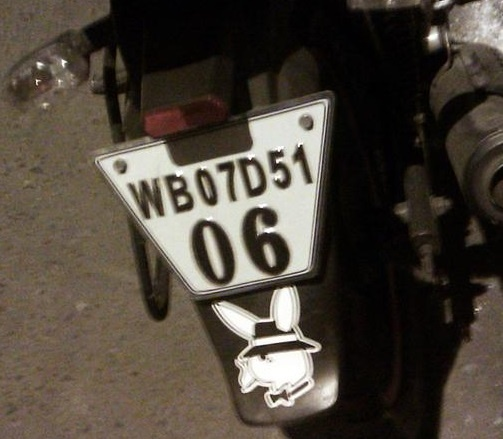

Ultralytics 8.3.25 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 135.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 214.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 250.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 259.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 283.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 19.3s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slim

In [15]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/content/data/data.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device="0",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("/content/data/test/images/N132.jpeg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

In [16]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.onnx')
files.download('/content/runs/detect/train/weights/best.pt')
files.download('/content/runs/detect/train/weights/last.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
from google.colab import files
uploaded = files.upload()


Saving test_image1.jpg to test_image1.jpg
Saving test_image6.jpg to test_image6.jpg
Saving test_image7.jpg to test_image7.jpg


In [18]:
import os
os.makedirs('/content/test_images', exist_ok=True)

# Move files to this folder
for filename in uploaded.keys():
    os.rename(f'/content/{filename}', f'/content/test_images/{filename}')


In [19]:
model = YOLO("/content/runs/detect/train/weights/best.pt")


In [21]:
os.mkdir("/content/outputs")


image 1/1 /content/test_images/test_image1.jpg: 512x640 (no detections), 48.7ms
Speed: 13.8ms preprocess, 48.7ms inference, 10.0ms postprocess per image at shape (1, 3, 512, 640)


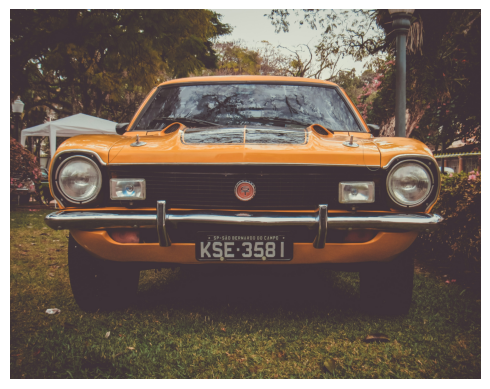


image 1/1 /content/test_images/test_image7.jpg: 448x640 2 number_plates, 73.8ms
Speed: 4.0ms preprocess, 73.8ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


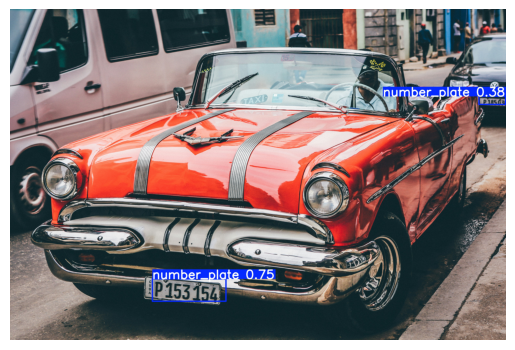


image 1/1 /content/test_images/test_image6.jpg: 448x640 1 number_plate, 24.9ms
Speed: 4.2ms preprocess, 24.9ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


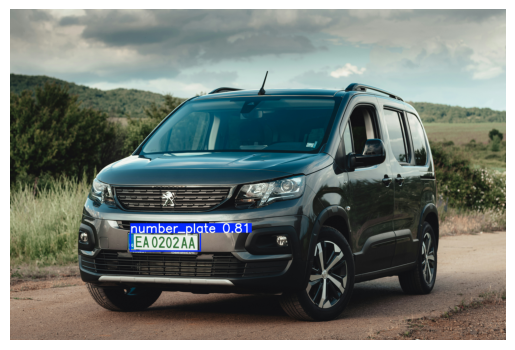

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Directory to save inference outputs
output_dir = "/content/outputs"
os.makedirs(output_dir, exist_ok=True)

# Loop through each uploaded image
for image in os.listdir('/content/test_images'):
    image_path = f'/content/test_images/{image}'
    results = model(image_path)  # Run inference

    # Save each result to the specified output directory and display it
    for idx, result in enumerate(results):
        output_path = os.path.join(output_dir, f"{os.path.splitext(image)[0]}_result_{idx}.jpeg")
        result.save(filename=output_path)  # Save to the specified filename

        # Display the saved image
        img = mpimg.imread(output_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()  # Display the image


In [24]:
import shutil

# Create a ZIP file of the outputs directory
shutil.make_archive("/content/inference_outputs", "zip", "/content/outputs")

# Download the ZIP file
from google.colab import files
files.download("/content/inference_outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>